In [1]:
import sys, os
from astropy.io import fits
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
from datetime import datetime as dt
import time
import _pickle as cPickle
import astropy.units as u
import imreg_dft
import numpy as np

from sunpy.coordinates import get_body_heliographic_stonyhurst, frames
from astropy.wcs import WCS
import reproject
from reproject import reproject_adaptive,reproject_exact,reproject_interp
from scipy.ndimage import map_coordinates

import sunpy.visualization.colormaps
font = {'family' : 'Open Sans',
        'weight' : 'normal',
        'size'   : 15}

import sunpy.visualization.colormaps as cm
import matplotlib as mpl
magmap = mpl.colormaps['hmimag']

import matplotlib.patches as patches
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

/scratch/slam/sinjan/.conda/envs/p310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(reproject.__version__)

0.1.dev1280+g51379b1.d20250122


In [3]:
def get_hrt_remapped_R(hrt_file, hmi_file, err):
    
    from datetime import datetime as dt
    print(dt.now())

    errx=err[0]
    erry=err[1]
    h = fits.getheader(hrt_file)
    h['CRVAL1']=h['CRVAL1']-errx
    h['CRVAL2']=h['CRVAL2']-erry
    tmp = fits.getdata(hrt_file)
    arr=np.zeros(tmp.shape)
    arr[150:-150,150:-150]=tmp[150:-150,150:-150]
    hrt_map = sunpy.map.Map(arr,h)

    #magnetogram = sunpy.map.Map(hmi_file).rotate()
    #hpc_coords = sunpy.map.all_coordinates_from_map(magnetogram)
    #mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
    #hmi_map = sunpy.map.Map(magnetogram.data, magnetogram.meta, mask=mask)
    hmi_map=sunpy.map.Map(hmi_file).rotate()

    out_header = sunpy.map.make_fitswcs_header(
         hmi_map.data.shape, hmi_map.reference_coordinate.replicate(rsun=hrt_map.reference_coordinate.rsun),
         scale=u.Quantity(hmi_map.scale),
         instrument="SO/PHI-HRT",
         observatory="SolO",
         wavelength=hrt_map.wavelength
         )
    out_header['dsun_obs'] = hmi_map.coordinate_frame.observer.radius.to(u.m).value
    out_header['hglt_obs'] = hmi_map.coordinate_frame.observer.lat.value
    out_header['hgln_obs'] = hmi_map.coordinate_frame.observer.lon.value
    
    out_header['crpix1'] = hmi_map.fits_header['CRPIX1']
    out_header['crpix2'] = hmi_map.fits_header['CRPIX2']
    out_header['crval1'] = hmi_map.fits_header['CRVAL1']
    out_header['crval2'] = hmi_map.fits_header['CRVAL2']    
    out_header['PC1_1'] = hmi_map.fits_header['PC1_1']
    out_header['PC1_2'] = hmi_map.fits_header['PC1_2']
    out_header['PC2_1'] = hmi_map.fits_header['PC2_1']
    out_header['PC2_2'] = hmi_map.fits_header['PC2_2']
    out_header['cdelt1'] = hmi_map.fits_header['cdelt1']
    out_header['cdelt2'] = hmi_map.fits_header['cdelt2']
    out_WCS=WCS(out_header)

    hrt_repro, footprint = reproject_adaptive(hrt_map, out_WCS, hmi_map.data.shape,kernel='Gaussian',sample_region_width=1,kernel_width=10000)
    hrt_repro=sunpy.map.Map((hrt_repro, out_WCS))
    
    return hrt_repro, hmi_map

In [4]:
filedir = '/data/solo/phi/data/fmdb/public/l2/2023-10-12/'
bfile = 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz'
hrt_file = filedir+bfile

hmifiledir = '/scratch/slam/sinjan/arlongterm_hmi/'
hmibfile = 'blos_45/hmi.m_45s.20231012_002145_TAI.2.magnetogram.fits'
hmi_file = hmifiledir+hmibfile

In [5]:
hrt_121023_b = fits.getdata(filedir+bfile)
hrt_121023_bm = sunpy.map.Map(filedir+bfile)
hmi_121023_b = sunpy.map.Map(hmifiledir+hmibfile).rotate()

In [6]:
def get_hmi_hrt_aligned(hrt_file,hmi_file):
    err=(-1.934214925750382, 113.7871115449891)
    hrt_remap, hmi_map = get_hrt_remapped_R(hrt_file, hmi_file, err)
    return [hrt_remap,hmi_map]

In [7]:
hrt,hmi=get_hmi_hrt_aligned(hrt_file,hmi_file)

2025-01-22 14:15:19.720658
4102/4102 done5440521.0



In [10]:
"""Using Hann but 0.5 in the padded scheme (it is flooring and ceiling residuals)
HMI target: x,y: (300, 2310)
t,b,l,r: (1068.0, 1066.0, 1424.0, 1433.0)
t_r,b_r,l_r,r_r: (0.8127020937240559, -0.765672618588269, -0.725801074795072, 0.23385714903406551)
Pixels: 30.0
"""

'Using Hann but 0.5 in the padded scheme\nHMI target: x,y: (300, 2310)\nt,b,l,r: (1068.0, 1066.0, 1424.0, 1433.0)\nt_r,b_r,l_r,r_r: (0.8127020937240559, -0.765672618588269, -0.725801074795072, 0.23385714903406551)\nPixels: 30.0\n'

In [ ]:
"""Using Hann but 0.5 in the padded scheme (but rounding)
HMI target: x,y: (300, 2310)
t,b,l,r: (1069.0, 1065.0, 1423.0, 1433.0)
t_r,b_r,l_r,r_r: (-0.18729790627594411, 0.23432738141173104, 0.27419892520492795, 0.23385714903406551)
Pixels: 55.0
"""

In [11]:
"""From Gaussian Kernel file
HMI target: x,y: (300, 2310) 
t,b,l,r: (1071.0, 1063.0, 1424.0, 1432.0)
t_r,b_r,l_r,r_r: (0.4960384940397944, -0.44900901890400746, -0.2184957193524042, 0.7265517935913977)
Pixels: 81.0
Pix count: 7418448.0
"""

'From Gaussian Kernel file\nHMI target: x,y: (300, 2310) \nt,b,l,r: (1071.0, 1063.0, 1424.0, 1432.0)\nt_r,b_r,l_r,r_r: (0.4960384940397944, -0.44900901890400746, -0.2184957193524042, 0.7265517935913977)\nPixels: 81.0\nPix count: 7418448.0\n'

In [12]:
"""From Hann Kernel file
HMI target: x,y: (300, 2310)
t,b,l,r: (1070.0, 1064.0, 1419.0, 1438.0)
t_r,b_r,l_r,r_r: (0.6018894498802183, -0.5548599747444314, -0.7056301867094135, 0.21368626094840693)
Pixels: 140.0
Pix count: 9016936.0
"""

'From Hann Kernel file\nHMI target: x,y: (300, 2310)\nt,b,l,r: (1070.0, 1064.0, 1419.0, 1438.0)\nt_r,b_r,l_r,r_r: (0.6018894498802183, -0.5548599747444314, -0.7056301867094135, 0.21368626094840693)\nPixels: 140.0\nPix count: 9016936.0\n'

In [8]:
import ast

def get_t_b_l_r_from_log(log_file,x_hmi,y_hmi):
    with open(log_file) as f:
        lines = f.readlines()

    lines = [s.strip() for s in lines] #get rid of newline character

    target = f'HMI target: x,y: {x_hmi, y_hmi}'
    line_index = lines.index(target)

    edges = ast.literal_eval(lines[line_index+1].split(': ')[1])
    return edges

In [9]:
edges=get_t_b_l_r_from_log('./log_arlongterm.txt',300,2310)

In [10]:
def get_phi_pixels_and_neighbours_from_log_edges(log_file,x_hmi,y_hmi,neighbour_length):
    phi_out_dicts = {}
    for x_offset in range(-neighbour_length,neighbour_length+1):
        neigh_x = int(x_hmi + x_offset)
        for y_offset in range(-neighbour_length,neighbour_length+1):
            neigh_y = int(y_hmi + y_offset)
            t,b,l,r = get_t_b_l_r_from_log(log_file,neigh_x,neigh_y)
            phi_out_dicts[f'HMI {(neigh_x,neigh_y)} bleft']=(l,b)
            phi_out_dicts[f'HMI {(neigh_x,neigh_y)} tright']=(r,t)

    return phi_out_dicts

In [11]:
def plot_reproject_from_log(phi_out_dict,hmi_map,phi_map,title='Reproject',fontsize=16):
    hmi_pixels = list(set([(int(i.split('(')[1].split(')')[0].split(', ')[0]),\
                            int(i.split('(')[1].split(')')[0].split(', ')[1])) \
                           for i in phi_out_dict.keys()]))
    
    min_x_hmi_lim = min(set([i[0] for i in hmi_pixels]))-5
    max_x_hmi_lim = max(set([i[0] for i in hmi_pixels]))+5

    min_y_hmi_lim = min(set([i[1] for i in hmi_pixels]))-5
    max_y_hmi_lim = max(set([i[1] for i in hmi_pixels]))+5

    plt.figure(figsize=(12,20))
    plt.subplot(211)
    hmi_map.data[np.isnan(hmi_map.data)]=0
    
    hpc_coords = sunpy.map.all_coordinates_from_map(hmi_map)
    mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
        
    im=plt.imshow(hmi_map.data*~mask,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
    plt.colorbar(im)
    plt.ylim(min_y_hmi_lim,max_y_hmi_lim)
    plt.xlim(min_x_hmi_lim,max_x_hmi_lim)
    for pix in hmi_pixels:
        plt.scatter(pix[0],pix[1],marker='X',s=10)
    drms_id = hmi_map.meta['drms_id']
    plt.title(f'{drms_id} - {hmi_map.date}')

    plt.subplot(212)
    im2=plt.imshow(phi_map.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)

    ax=plt.gca()

    blks = []
    trks = []
    for pix in hmi_pixels:
        pix_dicts = {k: phi_out_dict[k] for k in phi_out_dict.keys() if str(pix) in k}
        blk = pix_dicts.get(f'HMI {pix} bleft')
        trk = pix_dicts.get(f'HMI {pix} tright')

        blks.append(blk)
        trks.append(trk)
        
        blx = blk[0]
        bly = blk[1] 
        trx = trk[0]
        tryy = trk[1] 
        rect = patches.Rectangle((blx, bly), trx-blx, tryy-bly, linewidth=1, facecolor='none', edgecolor='black')
        ax.add_patch(rect)

        centrex = blx + (trx-blx)/2 # obviously use a different formula for different shapes
        centrey = bly + (tryy-bly)/2
        plt.text(centrex, centrey,f'{pix}',horizontalalignment = 'center',verticalalignment = 'center',fontsize=fontsize)

    phi_x_min_lim = min(set([i[0] for i in blks]))-10
    phi_x_max_lim = max(set([i[0] for i in trks]))+10

    phi_y_min_lim = min(set([i[1] for i in blks]))-10
    phi_y_max_lim = max(set([i[1] for i in trks]))+10

    plt.xlim(phi_x_min_lim,phi_x_max_lim)
    plt.ylim(phi_y_min_lim,phi_y_max_lim)
    filename = phi_map.meta['filename']
    plt.title(f'{filename} - {phi_map.date}')
    plt.colorbar(im2,fraction=0.036)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

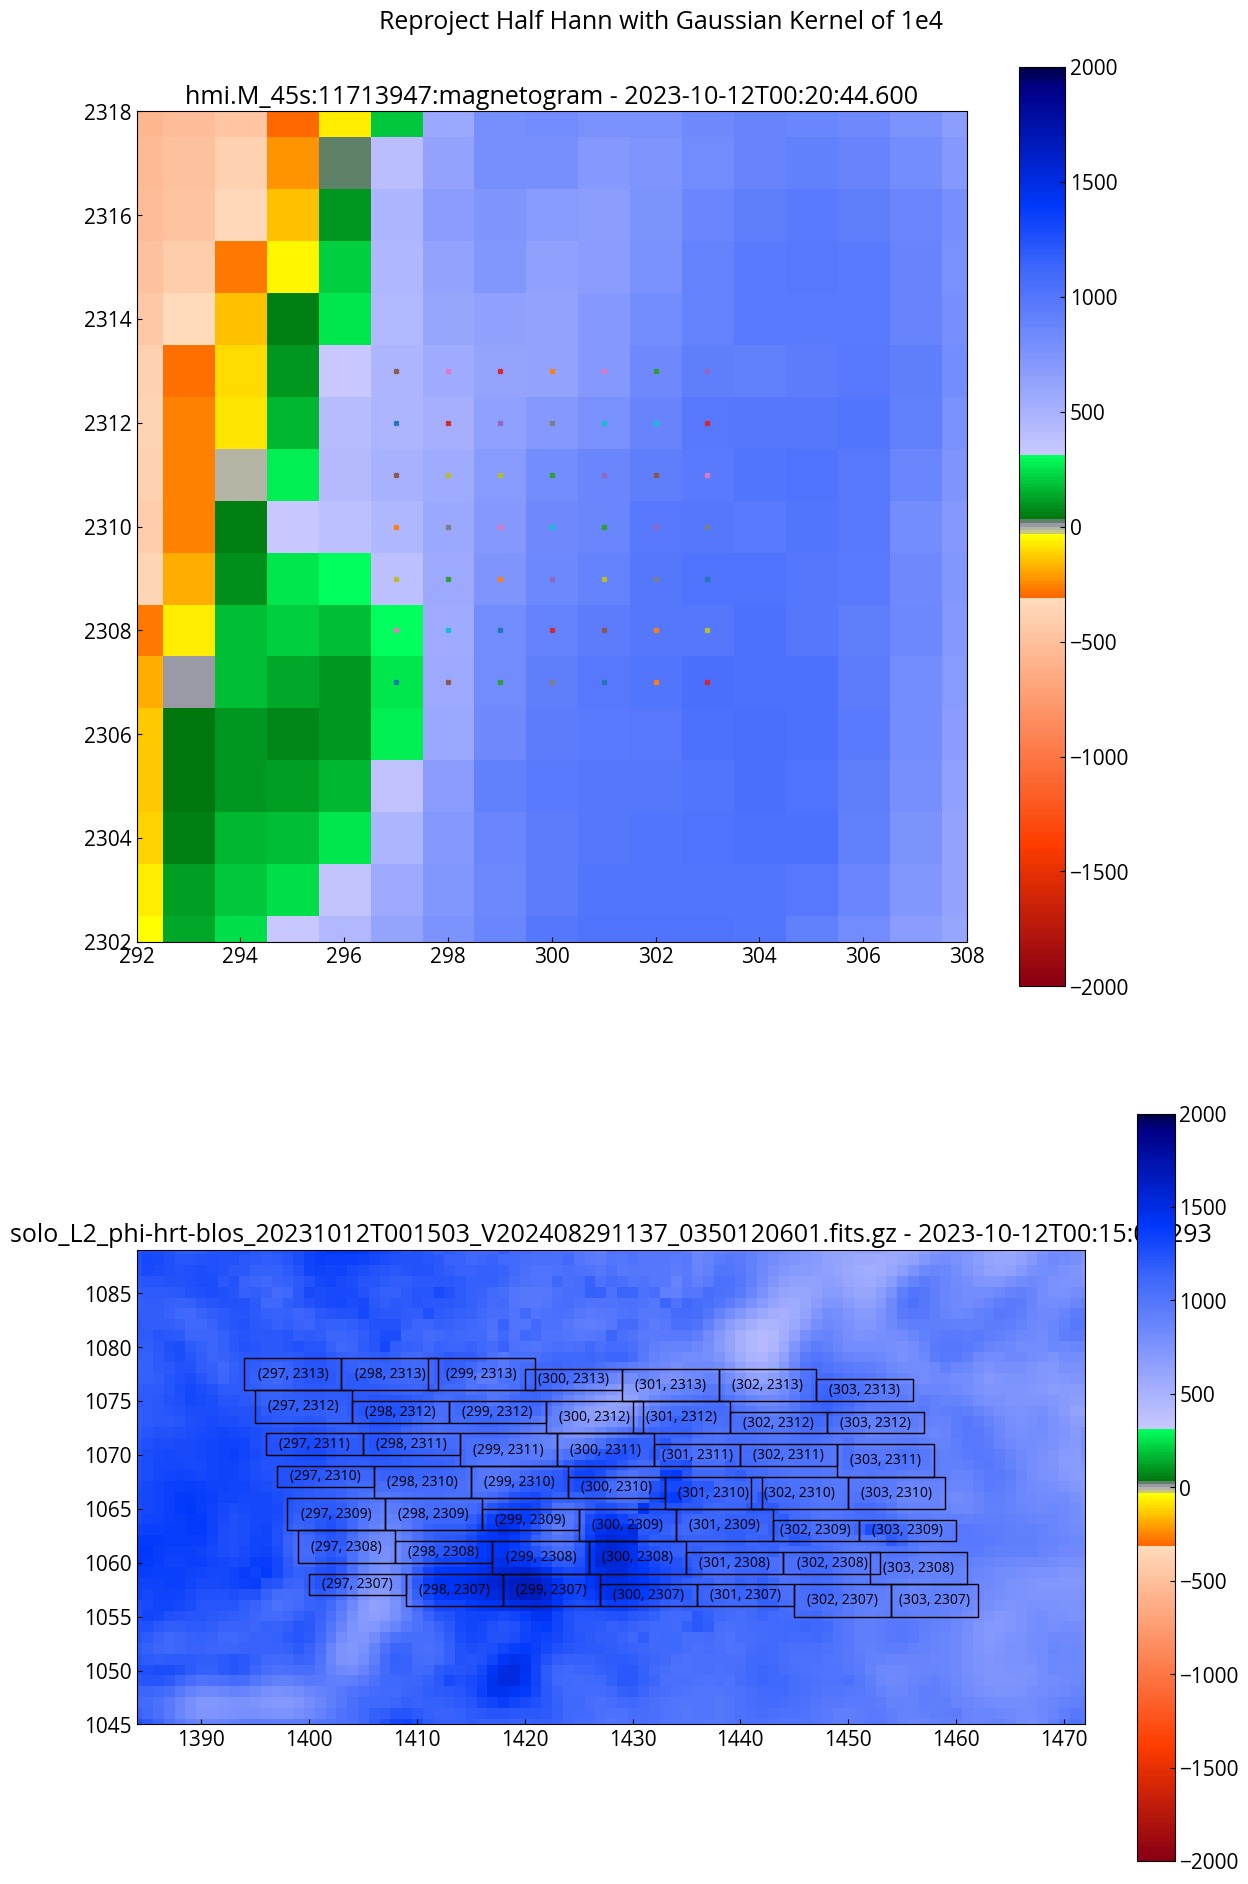

In [15]:
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm_half_hann_gaussian_weights.txt',300,2310,3)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Half Hann with Gaussian Kernel of 1e4',fontsize=10)

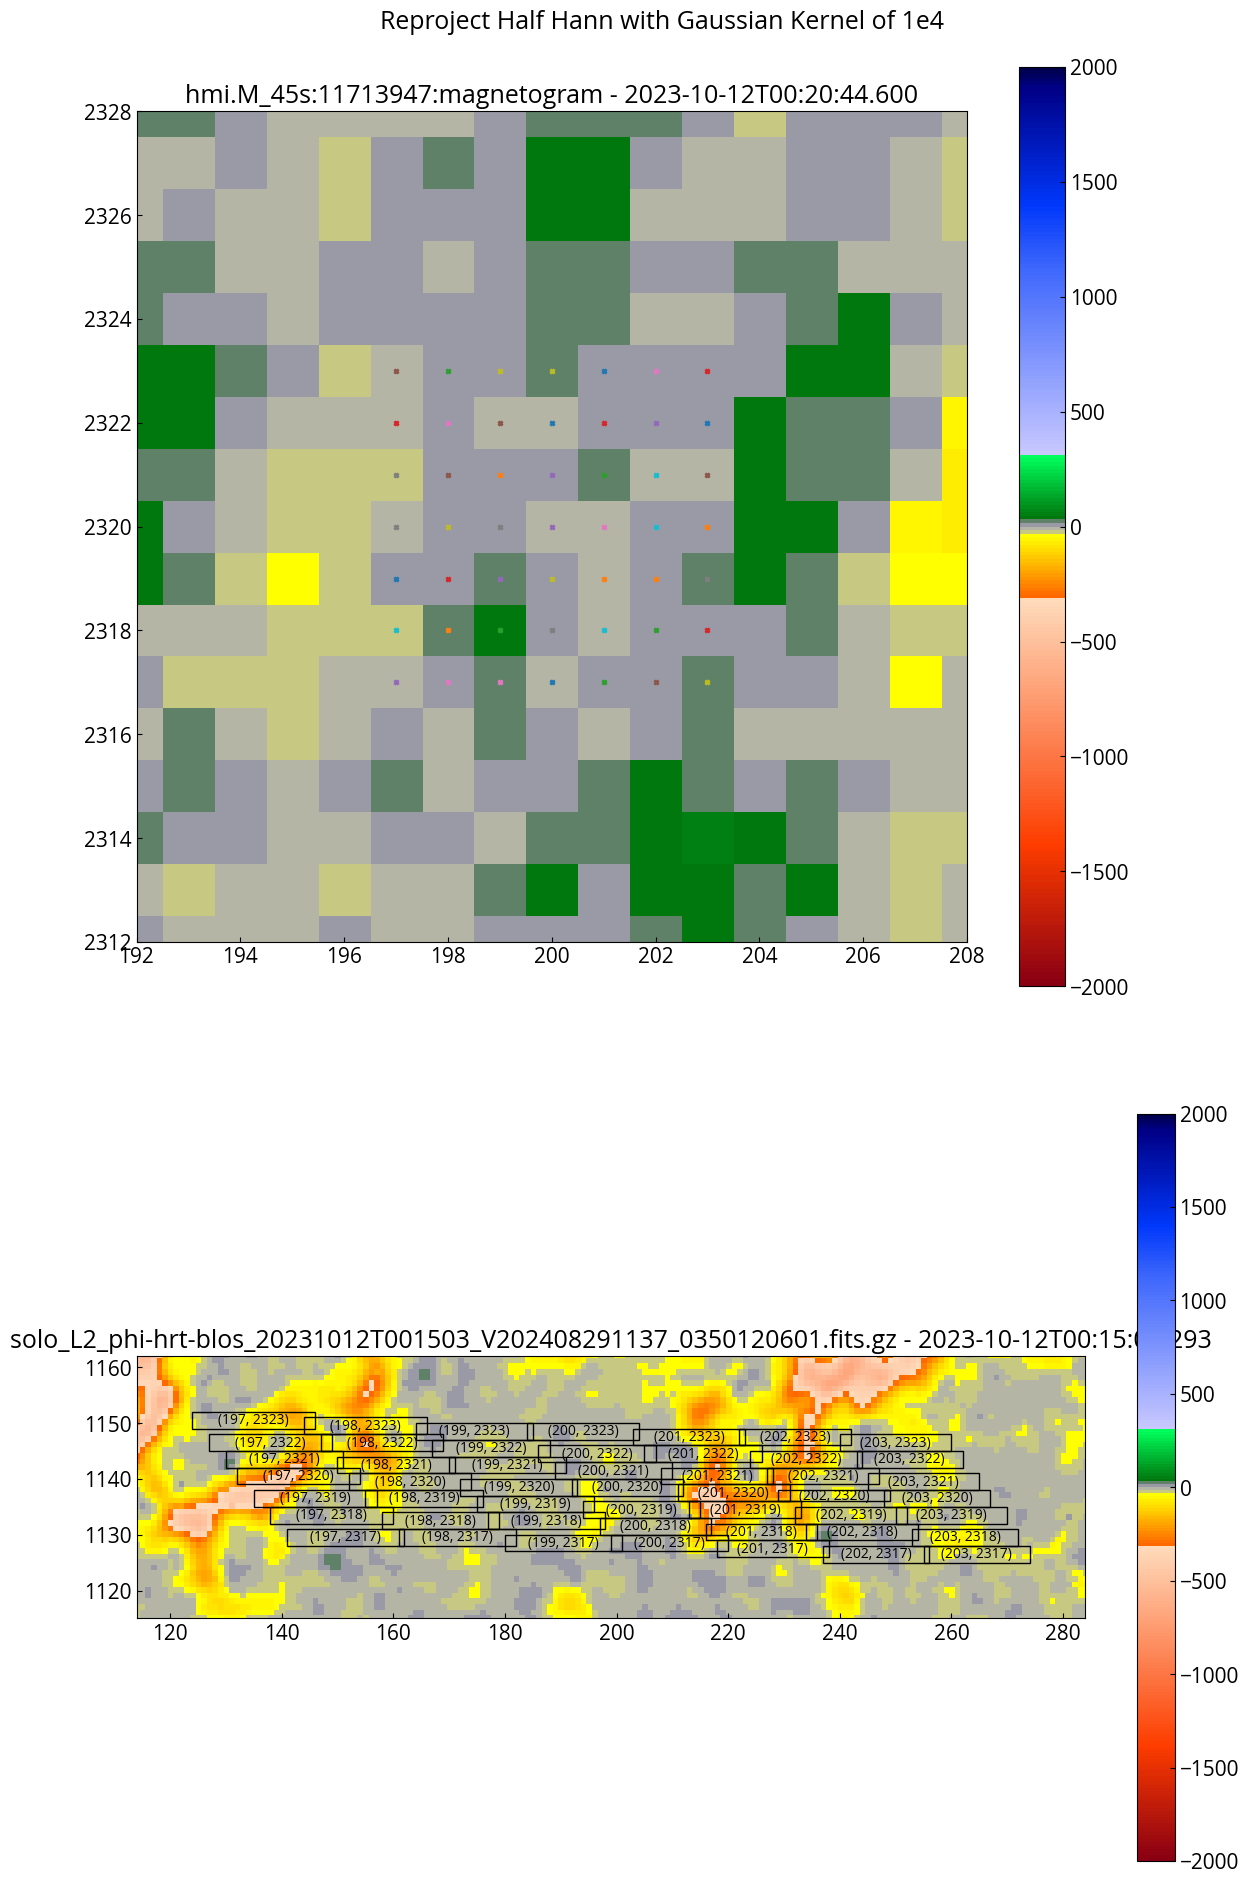

In [16]:
#200,2330,3
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm_half_hann_gaussian_weights.txt',200,2320,3)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Half Hann with Gaussian Kernel of 1e4',fontsize=10)

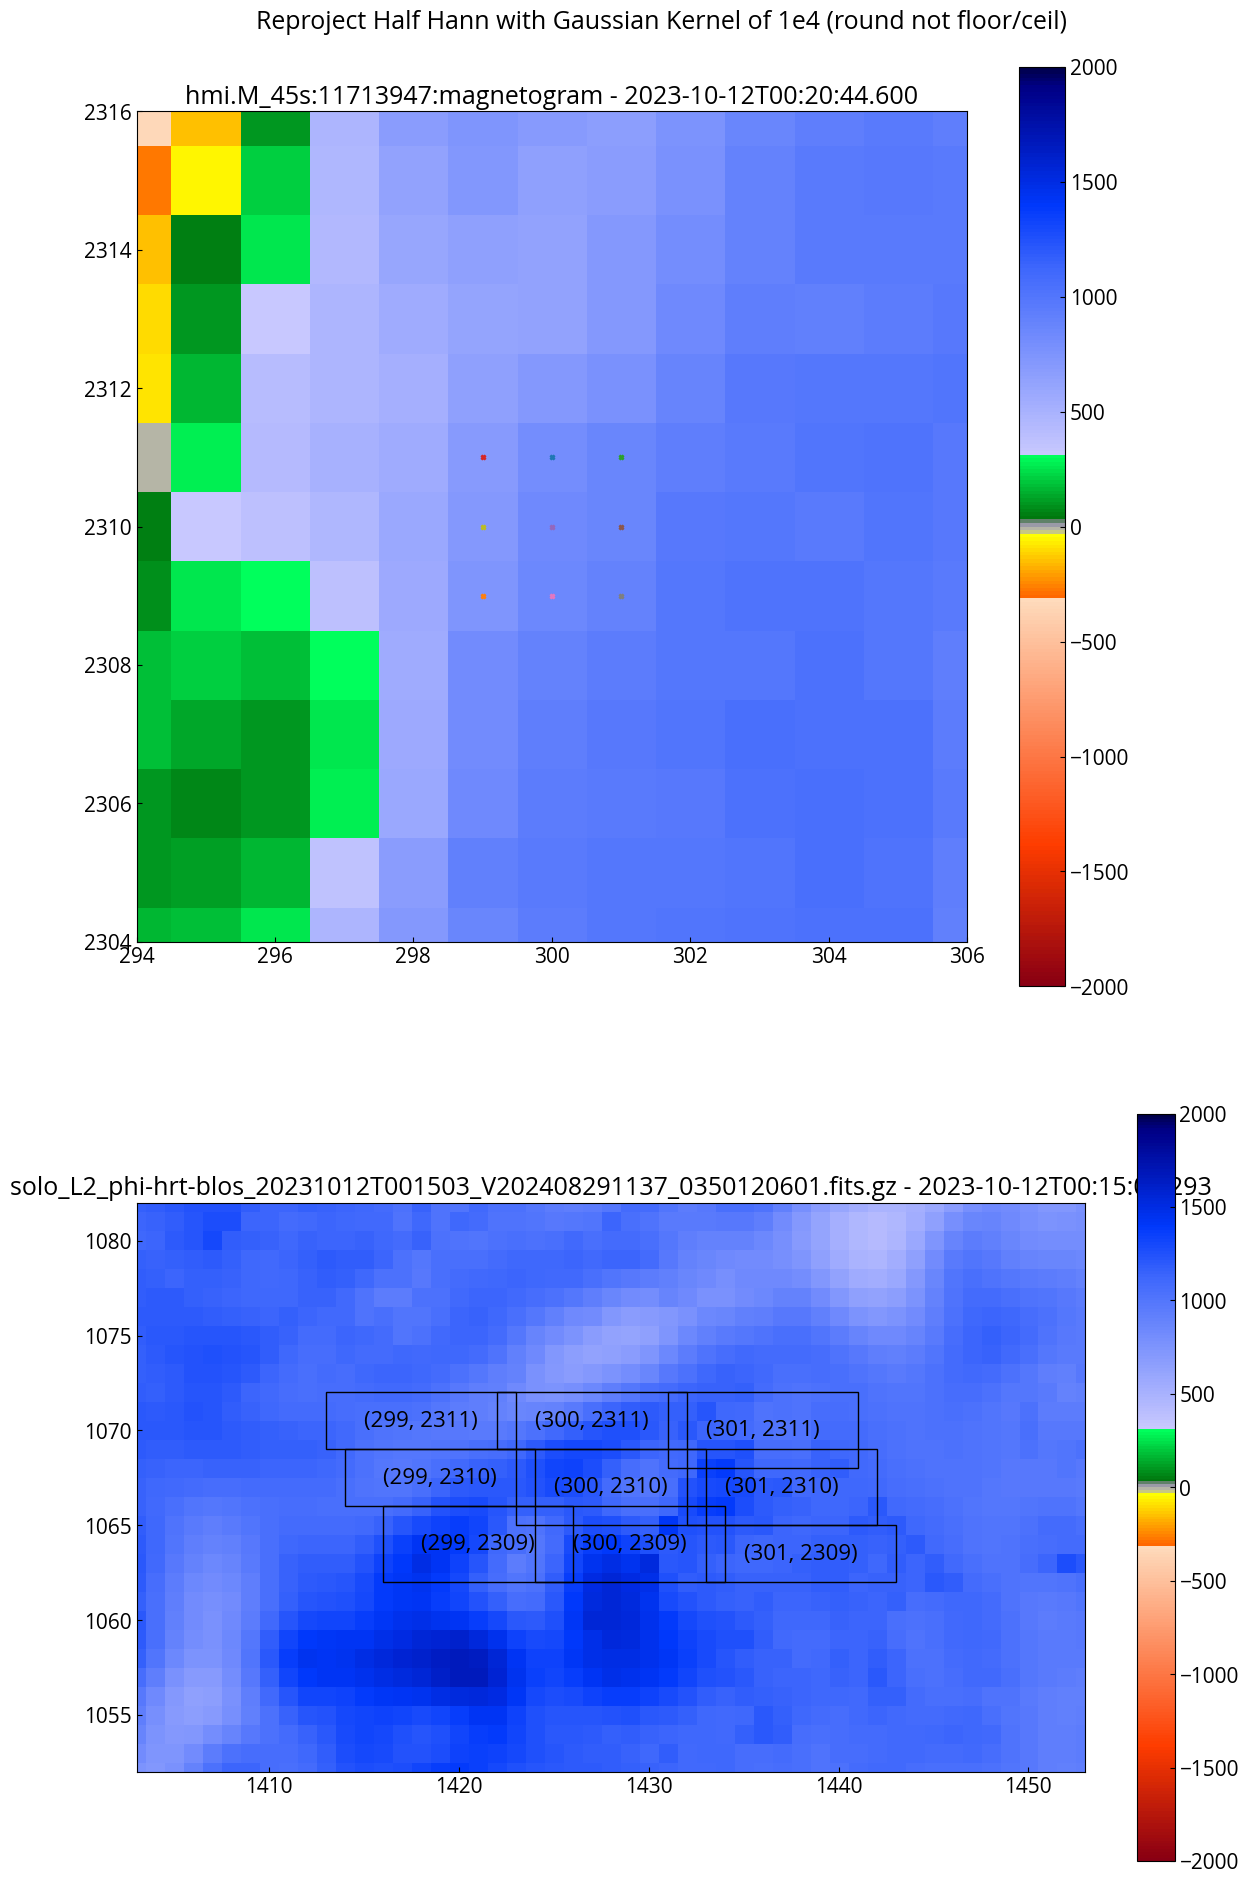

In [12]:
phi_dict=get_phi_pixels_and_neighbours_from_log_edges('./log_arlongterm.txt',300,2310,1)
plot_reproject_from_log(phi_dict,hmi_121023_b,hrt_121023_bm,title='Reproject Half Hann with Gaussian Kernel of 1e4 (round not floor/ceil)',fontsize=16)

In [17]:
#plot the Hann filter used:

def hanning_filter(x, y):
    x = np.abs(x)
    y = np.abs(y)
    if x >= 1 or y >= 1:
        return 0
    return (np.cos(x * np.pi)+1.0) * (np.cos(y * np.pi)+1.0)

In [54]:
x = np.linspace(-1,1,6)
y = np.linspace(-1,1,16)
X,Y = np.meshgrid(x,y)

In [55]:
hann_filter = np.zeros((6,16))

for i,ii in enumerate(x):
    for j,jj in enumerate(y):
        hann_filter[i,j] = hanning_filter(ii, jj)

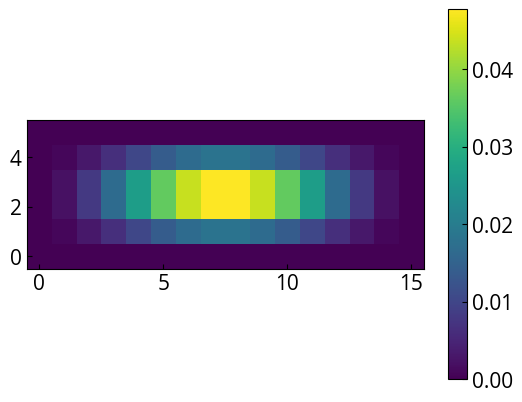

In [75]:
plt.imshow(hann_filter/np.sum(hann_filter),origin="lower")
plt.colorbar()

In [31]:
np.sum(hann_filter/np.sum(hann_filter))

1.0

In [80]:
phi_test_map = hrt_121023_bm.data[1065:1071,1420:1436]

out = np.sum(hann_filter*phi_test_map)/(np.sum(hann_filter))

In [81]:
out

1179.4419041666827

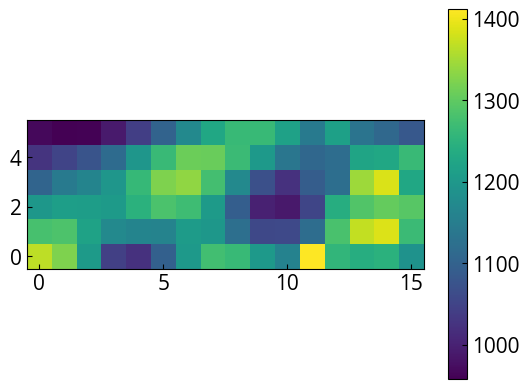

In [64]:
plt.imshow(phi_test_map,origin="lower")
plt.colorbar()

In [73]:
np.mean(hrt_121023_bm.data[1066:1069,1424:1432])

1157.5118